<a href="https://colab.research.google.com/github/gammaflauge/kaggle-digit-recognizer/blob/master/digit_recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/c/digit-recognizer/data

# Competition Description
MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms. As new machine learning techniques emerge, MNIST remains a reliable resource for researchers and learners alike.

In this competition, your goal is to correctly identify digits from a dataset of tens of thousands of handwritten images. We’ve curated a set of tutorial-style kernels which cover everything from regression to neural networks. We encourage you to experiment with different algorithms to learn first-hand what works well and how techniques compare.

# fast.ai boilerplate
https://course.fast.ai/videos/?lesson=1

In [44]:
!curl -s https://course.fast.ai/setup/colab | bash

%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *

np.random.seed(2)

Updating fastai...
Done.


# data initialization

In [0]:
import shutil

data_dir = "kaggle-digit-recognizer"
if os.path.exists(data_dir):
    shutil.rmtree(data_dir)

In [47]:
! git clone https://github.com/gammaflauge/kaggle-digit-recognizer.git

Cloning into 'kaggle-digit-recognizer'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 9 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (9/9), done.


In [50]:
import os
from zipfile import ZipFile

with ZipFile(f"./{ data_dir }/digit-recognizer.zip", "r") as z:
    z.extractall("./data")

print(f"files = { os.listdir('./data') }")

train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

print(f"train = { len(train) }, test = { len(test) }")

files = ['sample_submission.csv', 'train.csv', 'test.csv']
train = 42000, test = 28000


In [0]:
# make directories as required for fastai `from_folder`
# help from -- https://www.kaggle.com/christianwallenwein/beginners-guide-to-mnist-with-fast-ai
if not os.path.exists("./fastai"):
    os.makedirs("./fastai")

if not os.path.exists("./fastai/test"):
    os.makedirs("./fastai/test")

for i in range(0, 10):
    if not os.path.exists(f"fastai/train/{i}"):
        os.makedirs(f"./fastai/train/{i}")

# inspect the data

In [51]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [53]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# convert pixel arrays to images

In [0]:
from PIL import Image

def saveDigit(digit, filepath):
    digit = digit.reshape(28,28)
    digit = digit.astype(np.uint8)

    img = Image.fromarray(digit)
    img.save(filepath)

In [57]:
# save training images
for index, row in train.iterrows():
    label, digit = row[0], row[1:]
    filepath = f"./fastai/train/{ label }/{ index }.jpg"
    digit = digit.values
    saveDigit(digit, filepath)

total_images = 0
for i in range(10):
    print(f"{ len(os.listdir(f'./fastai/train/{ i }')) } images labels { i }")
    total_images += len(os.listdir(f'./fastai/train/{ i }'))

print(f"all done -- { total_images } saved training images")
assert total_images == len(train)

4132 images labels 0
4684 images labels 1
4177 images labels 2
4351 images labels 3
4072 images labels 4
3795 images labels 5
4137 images labels 6
4401 images labels 7
4063 images labels 8
4188 images labels 9
all done -- 42000 saved training images


In [58]:
# save test images
for index, row in test.iterrows():
    filepath = f"./fastai/test/{ index }.jpg"

    saveDigit(row.values, filepath)

print(f"all done, { len(os.listdir('./fastai/test')) } images in test dir")
assert len(os.listdir('./fastai/test')) == len(test)

all done, 28000 images in test dir


# view image files

In [0]:
# import matplotlib to arrange the images properly
import matplotlib.pyplot as plt

def displayTrainingData():
    fig = plt.figure(figsize=(5,10))
    path = f"./fastai/train"
    for i in range(0, 10):
        images = os.listdir(f"{ path }/{ i }")
        for sampleIndex in range(1, 6):
            randomNumber = random.randint(0, len(images)-1)
            image = Image.open(f"{ path }/{ i }/{ images[randomNumber] }")
            ax = fig.add_subplot(10, 5, 5*i + sampleIndex)
            ax.axis("off")
            
            plt.imshow(image, cmap='gray')
        
    plt.show()
    
def displayTestingData():
    fig = plt.figure(figsize=(5, 10))
    images = os.listdir(f"./fastai/test")
    for i in range(0, 5):
        for sampleIndex in range(1, 6):
            randomNumber = random.randint(0, len(images)-1)
            image = Image.open(f"./fastai/test/{ images[randomNumber] }")
            ax = fig.add_subplot(10, 5, 5*i + sampleIndex)
            ax.axis("off")
            plt.imshow(image, cmap='gray')
        
    plt.show()

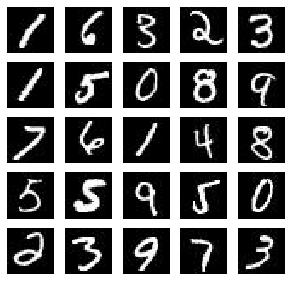

In [60]:
displayTestingData()

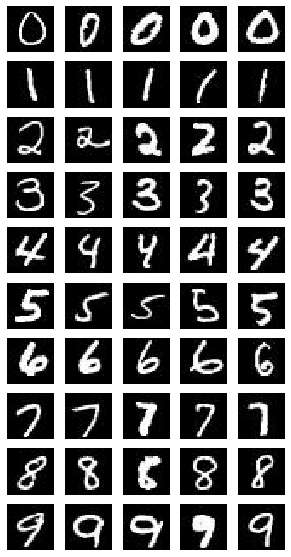

In [61]:
displayTrainingData()

# ✨ the magic ✨

In [0]:
data = ImageDataBunch.from_folder(
    path = f"./fastai",
    test = f"./test",
    valid_pct = 0.2,
    bs = 64,
    size = 28,
    ds_tfms = get_transforms(do_flip=False)
)

In [63]:
data = data.normalize()
data.classes

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

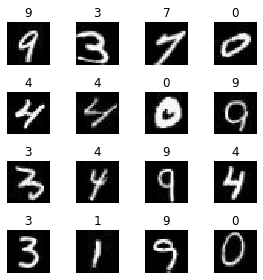

In [64]:
data.show_batch(rows=4, figsize=(4,4))

In [0]:
learn = cnn_learner(
    data,
    base_arch=models.resnet34,
    metrics=accuracy,
    callback_fns=ShowGraph
)

epoch,train_loss,valid_loss,accuracy,time
0,0.887915,0.569875,0.813214,00:58
1,0.451862,0.282448,0.907857,00:57
2,0.285024,0.182617,0.941071,00:57
3,0.264151,0.170464,0.945119,00:57


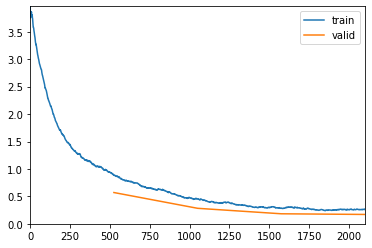

In [67]:
learn.fit_one_cycle(4)

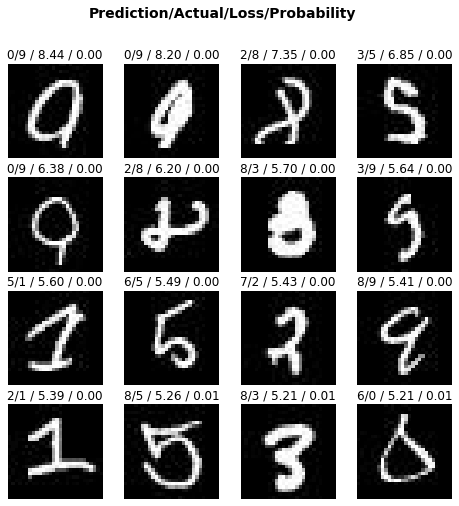

In [68]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
interp.plot_top_losses(16, figsize=(8,8))

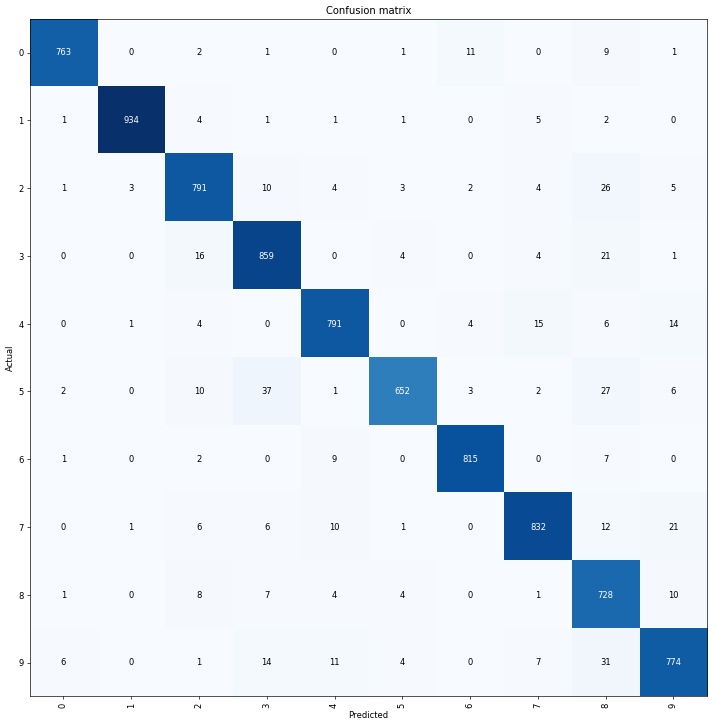

In [69]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [0]:
learn.save("untuned")

# 🔧 Tune it up

epoch,train_loss,valid_loss,accuracy,time
0,0.149522,0.065998,0.980476,01:03
1,0.115104,0.043699,0.986310,01:04
2,0.074890,0.035990,0.990833,01:05
3,0.036626,0.026770,0.992381,01:01
4,0.023908,0.021135,0.994286,01:00


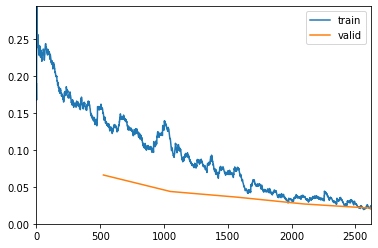

In [74]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


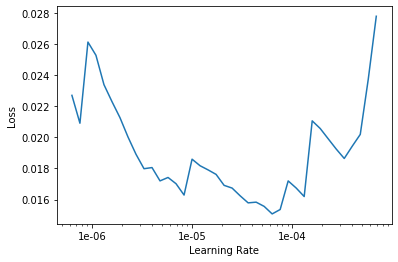

In [75]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.018612,0.020243,0.994286,01:00
1,0.026102,0.019773,0.994524,01:01


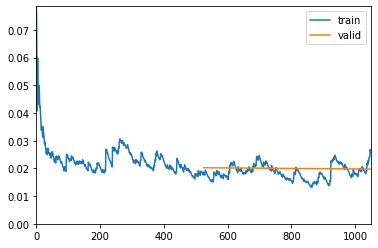

In [76]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

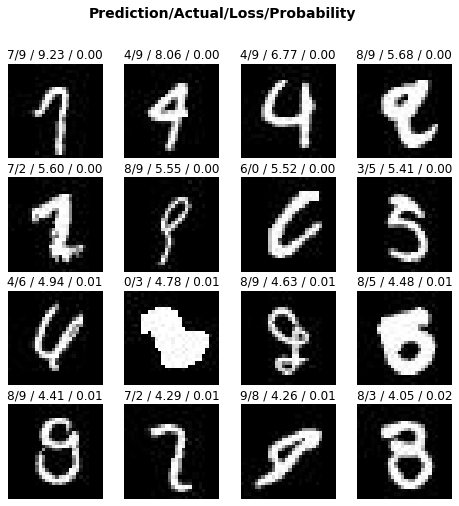

In [77]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
interp.plot_top_losses(16, figsize=(8,8))

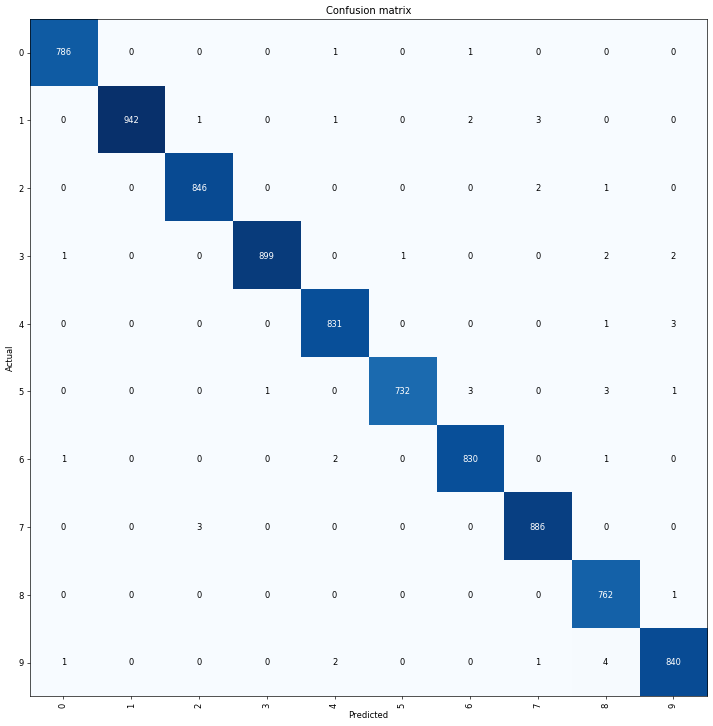

In [78]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [0]:
learn.save("tuned")

# 🏷 label the test dataset

In [80]:
class_score, y = learn.get_preds(DatasetType.Test)
class_score = np.argmax(class_score, axis=1)
assert len(class_score) == 28000

In [0]:
image_ids = [int(f[:-4]) + 1 for f in os.listdir("./fastai/test")]

submission  = pd.DataFrame({
    "ImageId": image_ids,
    "Label": class_score
})

submission = submission.sort_values(by="ImageId")
submission.to_csv("submission.csv", index=False)

In [82]:
submission.head()

,ImageId,Label
20913,1,2
20900,2,0
5880,3,9
24930,4,0
972,5,3


In [83]:
from google.colab import drive
drive.mount("/content/drive")

submission.to_csv("/content/drive/My Drive/Colab Notebooks/kaggle/submission.csv", index=False)
drive.flush_and_unmount()
print('All changes made in this colab session should now be visible in Drive.')

Mounted at /content/drive
All changes made in this colab session should now be visible in Drive.
